# Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Loading Data

In [2]:
with open("dataset/sbp_features.npy", "rb") as handler:
    sbp_features = np.load(handler)

In [3]:
with open("dataset/dbp_features.npy", "rb") as handler:
    dbp_features = np.load(handler)

# Preparing Data

In [4]:
x = sbp_features[:, :-1]
y = sbp_features[:, -1]

In [5]:
scaler = MinMaxScaler() # StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size = 0.3,
    shuffle = True,
    random_state = 1
)

# Evaluation Function

In [7]:
def evaluation_metrics(y_test, y_pred, plot = True):
    y_pred = y_pred.flatten()
    metrics = {
        "STD": np.std(y_pred - y_test),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": root_mean_squared_log_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }
    if plot:
        for key, value in metrics.items():
            print(key, value, sep = "\t")
    return metrics

In [8]:
def plot_tests(y_test, y_pred):
    y_pred = y_pred.flatten()
    
    plt.figure()
    # plt.scatter(list(range(len(y_test))), y_test, alpha = 0.5)
    # plt.scatter(list(range(len(y_pred))), y_pred, alpha = 0.5)
    plt.plot(y_test, label = "Real")
    plt.plot(y_pred, label = "Prediction")
    plt.show()
    
    plt.figure()
    plt.bar(list(range(len(y_test))), np.abs(y_test - y_pred))
    plt.show()

    plt.figure()
    plt.hist(y_pred.flatten() - y_test, bins = 100)
    plt.show()
    
    plt.figure()
    plt.hist(np.abs(y_pred.flatten() - y_test), bins = 100)
    plt.show()

In [9]:
def standards_stats(y_test, y_pred, threshold):
    y_pred = y_pred.flatten()
    return np.sum(np.abs(y_test - y_pred.flatten()) <= threshold) / len(y_test)

# Models

## Linear Regression

In [10]:
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_train, y_train)

0.217671233873044

In [11]:
y_pred = reg.predict(x_test)

In [12]:
metrics = evaluation_metrics(y_test, y_pred)

STD	26.286210903995016
MAE	21.444313749248533
MSE	695.1758574738784
RMSE	0.19846929013454026
R2	0.26219157966776274


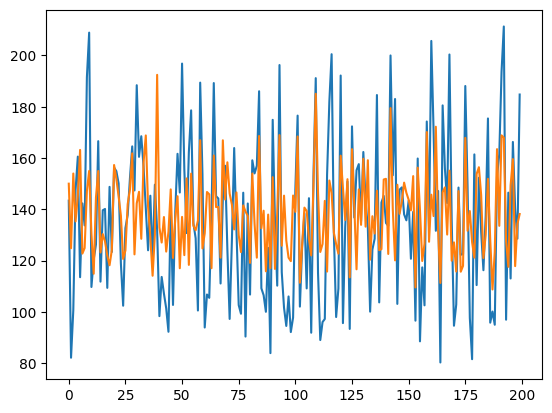

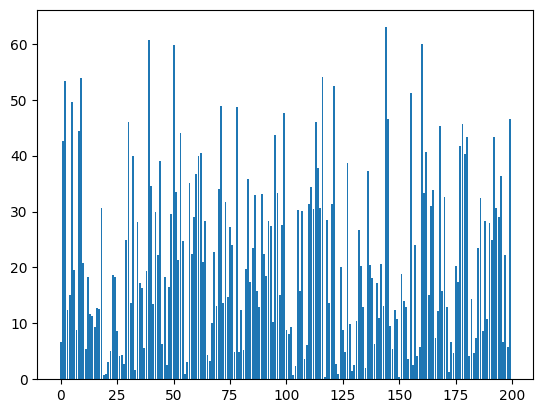

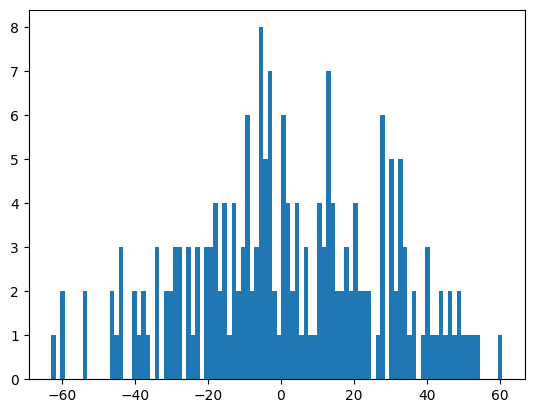

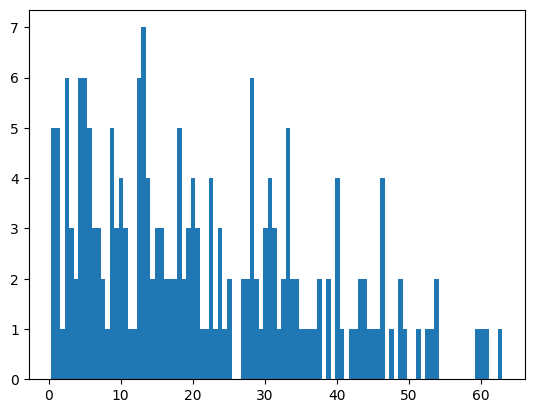

In [13]:
plot_tests(y_test, y_pred)

In [14]:
print(standards_stats(y_test, y_pred, 5))
print(standards_stats(y_test, y_pred, 10))
print(standards_stats(y_test, y_pred, 15))

0.16
0.285
0.42


## Gradient Boosting Regressor

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
gb = GradientBoostingRegressor(random_state=0)

parameters = {
    "n_estimators": [1000],
}

clf = GridSearchCV(gb, parameters, verbose = 1)

clf.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'n_estimators': [1000]}, verbose=1)

In [17]:
clf.score(x_train, y_train)

0.9998656155516824

In [18]:
y_pred = clf.predict(x_test)

In [19]:
metrics = evaluation_metrics(y_test, y_pred)

STD	23.206296632831176
MAE	18.26154062860855
MSE	538.9226302928543
RMSE	0.1725642073077822
R2	0.4280272390607208


In [20]:
print("5mmHg", standards_stats(y_test, y_pred, 5), sep = "\t")
print("10mmHg", standards_stats(y_test, y_pred, 10), sep = "\t")
print("15mmHg", standards_stats(y_test, y_pred, 15), sep = "\t")

5mmHg	0.185
10mmHg	0.335
15mmHg	0.52


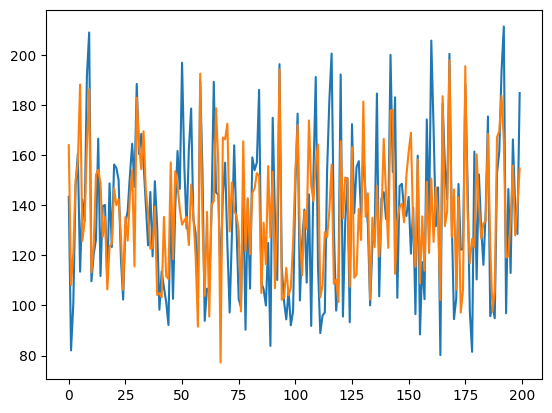

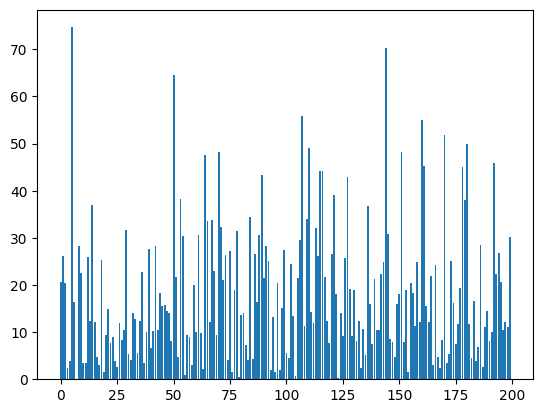

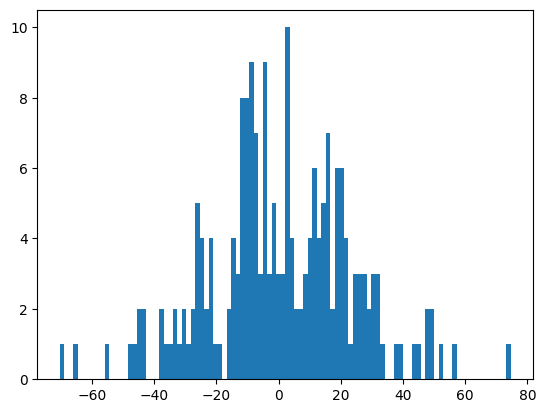

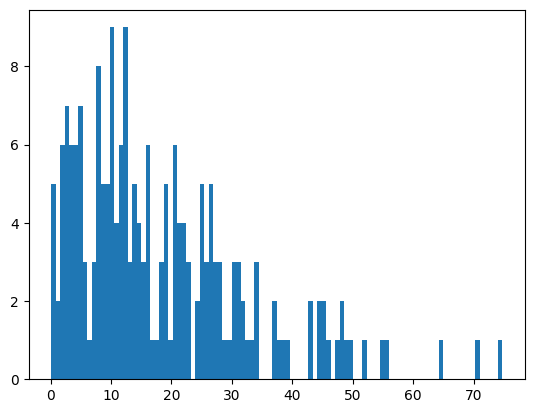

In [21]:
plot_tests(y_test, y_pred)

## SVR

In [22]:
svr = SVR()

parameters = {
    "C": list(np.arange(0.5, 5.5, 1)),
    # "degree": list(np.arange(1, 6)),
    # "epsilon": list(np.arange(0.1, 1.1, 0.1)),
    # # "gamma": ["scale", "auto"],
    # "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

clf = GridSearchCV(svr, parameters, verbose = 1)

clf.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=SVR(), param_grid={'C': [0.5, 1.5, 2.5, 3.5, 4.5]},
             verbose=1)

In [23]:
clf.score(x_train, y_train)

0.21225994807400517

In [24]:
y_pred = clf.predict(x_test)

In [25]:
metrics = evaluation_metrics(y_test, y_pred)

STD	26.62661777314899
MAE	21.766745272061154
MSE	709.0904881322267
RMSE	0.19804328610511157
R2	0.24742361620187348


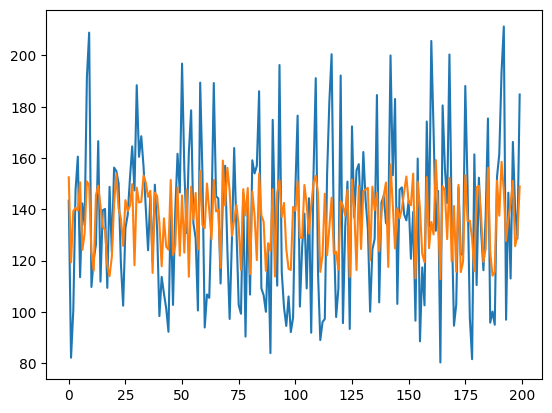

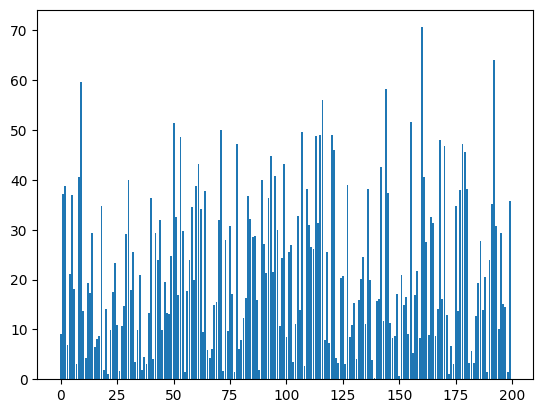

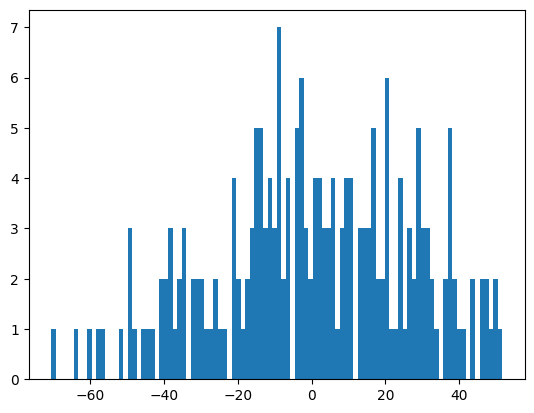

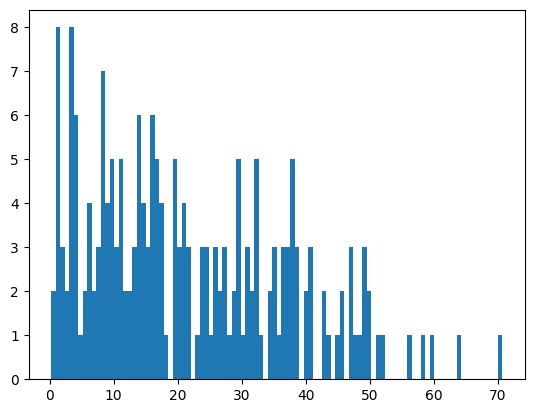

In [26]:
plot_tests(y_test, y_pred)

In [27]:
print(standards_stats(y_test, y_pred, 5))
print(standards_stats(y_test, y_pred, 10))
print(standards_stats(y_test, y_pred, 15))

0.15
0.285
0.41


## ANN

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GaussianNoise

2024-08-25 07:15:23.199342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 07:15:23.199993: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 07:15:23.202578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 07:15:23.210289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 07:15:23.222942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [29]:

def get_model (x):
    
    model = Sequential()
    model.add(Dense(x.shape[1], activation='elu', input_dim = x.shape[1]))
    # model.add(GaussianNoise(stddev = 1))
    model.add(Dense(16, activation='elu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(128, activation='elu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(64, activation='elu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(32, activation='elu'))
    model.add(Dense(1, activation = 'elu'))

    return model

In [30]:
model = get_model(x)

/home/oak/Projects/personal/blood-pressure-estimation/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724557524.471033   91807 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-25 07:15:24.471382: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the re

In [31]:
model.compile(optimizer='adam', loss = 'huber', metrics=['mae'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601 (6.25 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
EPOCHS = 150
history = model.fit(x_train, y_train, batch_size = 32, epochs = EPOCHS, validation_split = 0.1, verbose = 1)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 134.6532 - mae: 135.1532 - val_loss: 134.7300 - val_mae: 135.2300
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131.3375 - mae: 131.8375 - val_loss: 132.9966 - val_mae: 133.4966
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130.2694 - mae: 130.7694 - val_loss: 130.8249 - val_mae: 131.3249
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.1229 - mae: 126.6229 - val_loss: 128.0185 - val_mae: 128.5185
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123.4872 - mae: 123.9872 - val_loss: 124.3947 - val_mae: 124.8947
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.1331 - mae: 120.6331 - val_loss: 119.7923 - val_mae: 120.2923
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.9431 - mae: 117.4431 - val_loss: 113.9847 - val_mae: 114.4847
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.3002 - mae: 111.8002 - val_loss: 106.8281 - val_mae: 107.3281


In [34]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics]
        metric_name = [metric_name]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])
        
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

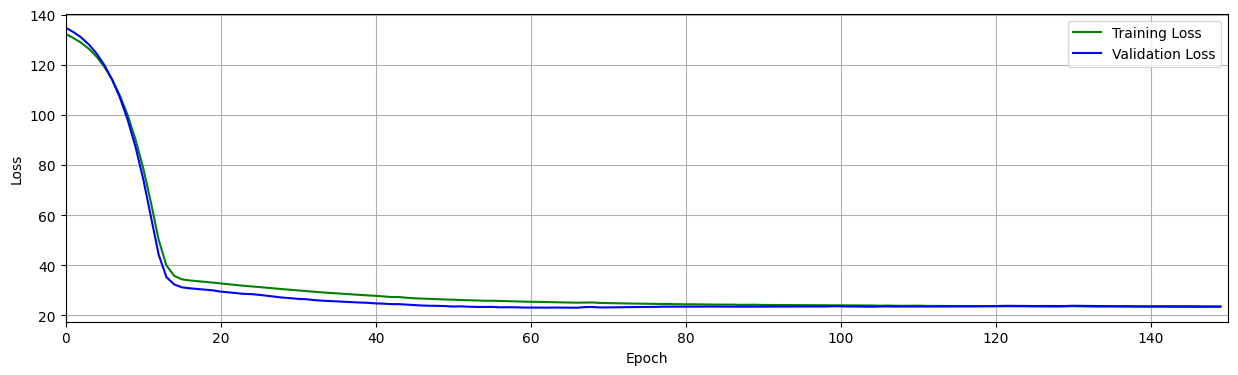

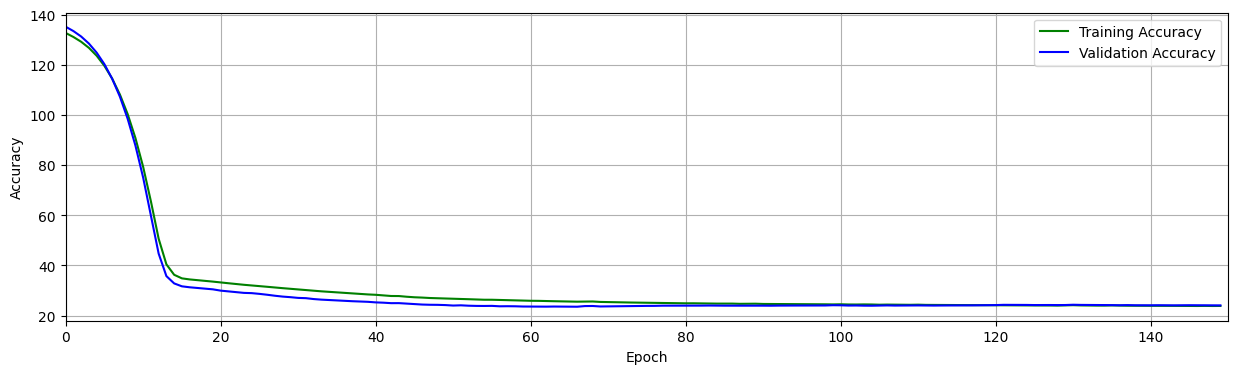

In [35]:
train_loss = history.history["loss"]
train_acc  = history.history["mae"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_mae"]

plot_results([train_loss, valid_loss],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([train_acc, valid_acc],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [36]:
y_pred = model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [37]:
metrics = evaluation_metrics(y_test, y_pred)

STD	28.529422053459015
MAE	23.187171211438244
MSE	813.9351477485732
RMSE	0.21319341300931943
R2	0.13614922158624287


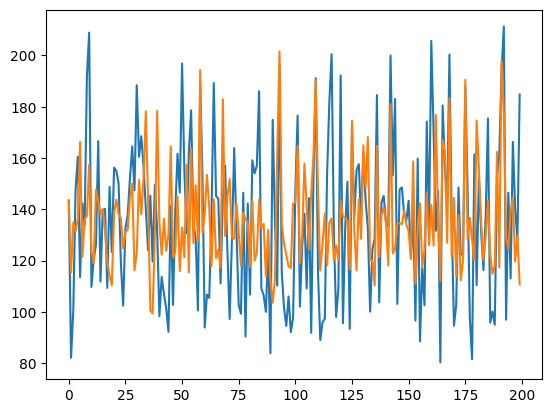

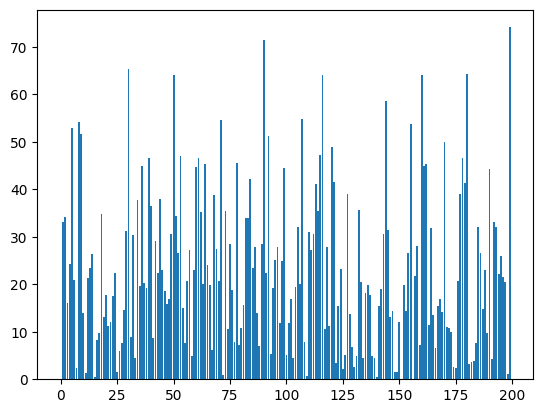

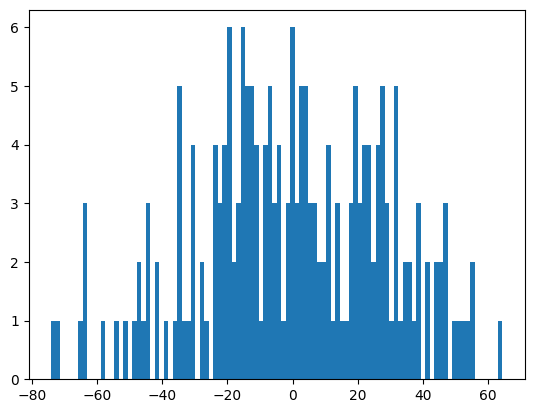

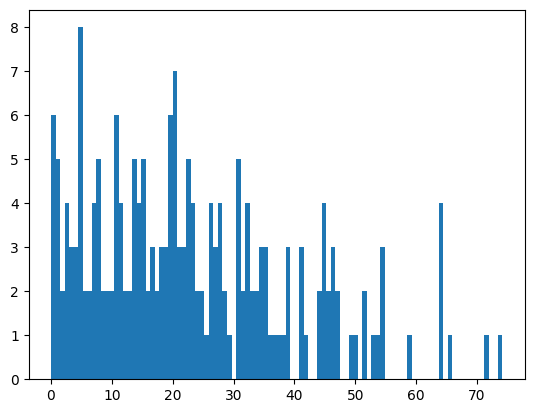

In [39]:
plot_tests(y_test, y_pred.flatten())

In [ ]:
print(standards_stats(y_test, y_pred, 5))
print(standards_stats(y_test, y_pred, 10))
print(standards_stats(y_test, y_pred, 15))